In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import re
import string
import os
import textwrap
import requests

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### `Step-1:` Creating Substitution Cipher

In [ ]:
# one will act as the key, other as the value
letters1 = list(string.ascii_lowercase) #key
letters2 = list(string.ascii_lowercase) #values

In [ ]:
print(letters1)

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [ ]:
# initializing an empty dictionary
true_mapping = {}

In [ ]:
# shuffle second set of letters
random.shuffle(letters2)

In [ ]:
# populate map
for k, v in zip(letters1, letters2):
    true_mapping[k] = v

In [ ]:
print(true_mapping)

{'a': 'e', 'b': 'g', 'c': 'f', 'd': 'a', 'e': 'y', 'f': 'd', 'g': 't', 'h': 'm', 'i': 's', 'j': 'i', 'k': 'q', 'l': 'u', 'm': 'c', 'n': 'j', 'o': 'k', 'p': 'n', 'q': 'w', 'r': 'v', 's': 'o', 't': 'b', 'u': 'x', 'v': 'p', 'w': 'h', 'x': 'z', 'y': 'l', 'z': 'r'}


### `Step-2:` Building the Language Model

In [ ]:
# # Downloading the file
if not os.path.exists('moby_dick.txt'):
    print('Downloading Moby dick...')
    r = requests.get('https://lazyprogrammer.me/course_files/moby_dick.txt')
    with open('moby_dick.txt','w') as f:
        f.write(r.content.decode())

In [ ]:
# Initialize Markov Matrix to store all the bigram probabilities
M = np.ones((26,26))    # Initialized with ones to incorporate add-one smoothing

# Also we need a vector to store the unigram probabilities
# initial state distribution
pi = np.zeros(26)

# update_transition: function to update the Markov Matrix
# ch1: first char, ch2: second char of the bigram
def update_transition(ch1,ch2):
    i = ord(ch1) - 97
    j = ord(ch2) - 97
    M[i,j] += 1 # We'll deal with probabilities later

# function to update the initial state distribution
def update_pi(ch):
    i = ord(ch) - 97
    pi[i] += 1

# get the log-probability of a token/word
def get_word_prob(word):
    # Computing unigram log probs
    i = ord(word[0]) -97
    logp = np.log(pi[i])

    # computing bigram log probabities
    for ch in word[1:]:
        j = ord(ch) -97
        logp += np.log(M[i,j]) #update prob
        i = j # update j
    return logp

# get the probability of a sequence of words
def get_sequence_prob(words):
    # if input is a sentence, split into a list of strings
    if type(words) == str:
        words = words.split()

    logp = 0
    for word in words:
        logp += get_word_prob(word)
    return logp

### `Step-3:` Training the Language Model

In [ ]:
# Creating a markov model based on an english dataset

# DATA PRE-PROCESSING

# For replacing non-alphabet chars
regex = re.compile('[^a-zA-Z]')

#load in words
for line in open('/content/moby_dick.txt'):
    line = line.rstrip()    # stripping out any white spaces
    # there aare blank lines in the file
    if line:
        line = regex.sub(' ',line) # replace all non-alpha characters with space

        # split the tokens in the line and lowercase
        tokens = line.lower().split()
#         print(tokens)
#         tokens = nltk.word_tokenize(tokens)

        # word --> token
        for token in tokens:
            # update the model
            # first letter
            ch0 = token[0]
            update_pi(ch0)

            # other letters
            for ch1 in token[1:]:
                update_transition(ch0,ch1)
                ch0 = ch1

# normalize the probabilities
pi /= pi.sum()
M /= M.sum(axis=1,keepdims=True)    # dividing each row by its row sum

In [ ]:
original_message = '''a poor fisherman  who lived on the fish he caught  had bad luck one day and caught nothing but a very small fry  the fisherman was about to put it in his basket when the little fish said    please spare me  mr  fisherman  i am so small it is not worth while to carry me home  when i am bigger  i shall make you a much better meal    but the fisherman quickly put the fish into his basket    how foolish i should be   he said   to throw you back  however small you may be  you are better than nothing at all'''

# original_message = 'bqqmf jt sfe'

In [ ]:
# a function to encode a message
def encode_message(msg):
    #downcase
    msg = msg.lower()

    # replace non-alpha characters
    msg = regex.sub(' ',msg)

    # make the encoded message
    coded_msg = []
    for ch in msg:
        coded_ch = ch
        if ch in true_mapping:
            coded_ch = true_mapping[ch]
        coded_msg.append(coded_ch)
    return ''.join(coded_msg)

# a function to decode a message
def decode_message(msg, word_map):
    decoded_msg = []
    for ch in msg:
        decoded_ch = ch
        if ch in word_map:
            decoded_ch = word_map[ch]
        decoded_msg.append(decoded_ch)
    return ''.join(decoded_msg)

In [ ]:
# Get the encoded message
encoded_message = encode_message(original_message)

In [ ]:
print(encoded_message)

q dool inhyeltqa  wyo fnseg oa xye inhy ye mqcvyx  yqg kqg fcmz oae gqu qag mqcvyx aoxynav kcx q selu htqff ilu  xye inhyeltqa wqh qkocx xo dcx nx na ynh kqhzex wyea xye fnxxfe inhy hqng    dfeqhe hdqle te  tl  inhyeltqa  n qt ho htqff nx nh aox wolxy wynfe xo mqllu te yote  wyea n qt knvvel  n hyqff tqze uoc q tcmy kexxel teqf    kcx xye inhyeltqa jcnmzfu dcx xye inhy naxo ynh kqhzex    yow ioofnhy n hyocfg ke   ye hqng   xo xylow uoc kqmz  yowesel htqff uoc tqu ke  uoc qle kexxel xyqa aoxynav qx qff


In [ ]:
# run an evolutionary algorithm to decode the message

# initialization point
dna_pool = []
for _ in range(30):
    dna = list(string.ascii_lowercase)
    random.shuffle(dna)
    dna_pool.append(dna)

In [ ]:
def evolve_offspring(dna_pool, n_children):
    # make n_children per offspring
    offspring = []
    for dna in dna_pool:
        for _ in range(n_children):
            copy = dna.copy()
            j = np.random.randint(len(copy))
            k = np.random.randint(len(copy))

            # switch
            tmp = copy[j]
            copy[j] = copy[k]
            copy[k] = tmp
            offspring.append(copy)
    return offspring + dna_pool

In [ ]:
num_iters = 1000
scores = np.zeros(num_iters)
best_dna = None
best_map = None
best_score = float('-inf')
for i in range(num_iters):
    if i>0:
        # get offspring from the current dna pool
        dna_pool = evolve_offspring(dna_pool,5)

    # calculate score for each dna
    dna2score ={}
    for dna in dna_pool:
        current_map = {}
        for k, v in zip(letters1,dna):
            current_map[k] = v

        decoded_message = decode_message(encoded_message, current_map)
        score = get_sequence_prob(decoded_message)  # Log likelihood of the decoded message

        #store it
        # needs to be a strin to be a dict key
        dna2score[''.join(dna)] = score

        # record te best so far
        if score > best_score:
            best_dna = dna
            best_map = current_map
            best_score = score
        # avg score
    scores[i] = np.mean(list(dna2score.values()))
        # keep 5 best dna
        # also turn them back into list of single chars
    sorted_dna = sorted(dna2score.items(), key =lambda x:x[1],reverse = True)
    dna_pool = [list(k) for k, v in sorted_dna[:5]]

    if i% 200 == 0:
        print('iter:',i,'score:',scores[i],'best so far:',best_score)

iter: 0 score: -2005.9258961848166 best so far: -1705.759573848804
iter: 200 score: -1091.7136798602803 best so far: -994.2528545404044
iter: 400 score: -1081.9036428430552 best so far: -992.9994607645239
iter: 600 score: -1121.475890629851 best so far: -992.9994607645239
iter: 800 score: -1091.973729217785 best so far: -992.9994607645239


In [ ]:
# use best score
# print(best_map)
# print(encoded_message)
# decoded_message = decode_message(encoded_message, best_map)
# print(decoded_message)
# print(original_message)
print('LL of decoded message:',get_sequence_prob(decoded_message))
print('LL of True message:',get_sequence_prob(regex.sub(' ',original_message.lower())))

# which letters are wrong
cnt = 1
for true, v in true_mapping.items():
    pred = best_map[v]
    if true != pred:
        print(f'{cnt}. true: {true}, pred: {pred}')
        cnt += 1

LL of decoded message: -992.9994607645239
LL of True message: -903.2860392780087
1. true: b, pred: h
2. true: c, pred: m
3. true: d, pred: v
4. true: f, pred: w
5. true: h, pred: t
6. true: j, pred: z
7. true: k, pred: p
8. true: m, pred: c
9. true: n, pred: d
10. true: p, pred: b
11. true: s, pred: n
12. true: t, pred: s
13. true: v, pred: k
14. true: w, pred: f
15. true: z, pred: j


In [ ]:
generated_txt = textwrap.fill(decoded_message)
# print the final decoded message
print('Decoded message:\n',textwrap.fill(decoded_message))

print('\n True message:\n', textwrap.fill(original_message))

print('\n Encoded Message:\n',encoded_message)

Decoded message:
 a boor wintercam  fto likev om ste wint te daupts  tav hav ludg ome
vay amv daupts mostimp hus a kery ncall wry  ste wintercam fan ahous
so bus is im tin hanges ftem ste lissle wint naiv    bleane nbare ce
cr  wintercam  i ac no ncall is in mos forst ftile so darry ce toce
ftem i ac hipper  i ntall cage you a cudt hesser ceal    hus ste
wintercam quidgly bus ste wint imso tin hanges    tof woolint i ntoulv
he   te naiv   so strof you hadg  tofeker ncall you cay he  you are
hesser stam mostimp as all

 True message:
 a poor fisherman  who lived on the fish he caught  had bad luck one
day and caught nothing but a very small fry  the fisherman was about
to put it in his basket when the little fish said    please spare me
mr  fisherman  i am so small it is not worth while to carry me home
when i am bigger  i shall make you a much better meal    but the
fisherman quickly put the fish into his basket    how foolish i should
be   he said   to throw you back  however small yo

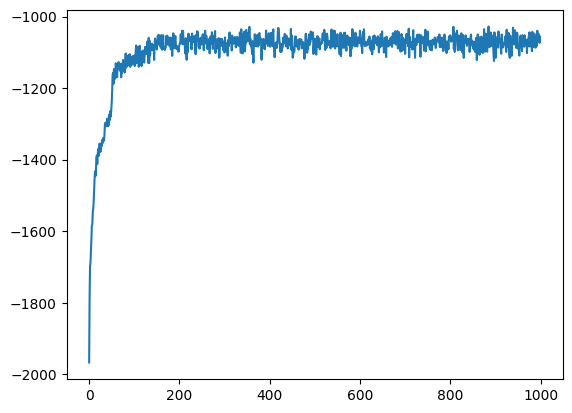

In [ ]:
plt.plot(scores)
plt.show()

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
score = sentence_bleu([original_message], generated_txt)
print(score)

0.3739804506521141
